In [1]:
import os, sys
sys.path.append(os.path.abspath(os.path.join('../../..'))) # access sibling directories

from src.python.models import HierarchicalSdtMptSimulator, MainSimulator

import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

In [2]:
# Hack to correctly set facecolor to white
# matplotlib 3.5 only sets facecolor if a plot was already created 
_ = plt.figure()
plt.rcParams['figure.facecolor'] = 'w'

<Figure size 432x288 with 0 Axes>

# Model formulation

We define stimulus type and response as
- 0 = "new"
- 1 = "old".

## Hierarchical Signal-Detection model (equal variance model)

Hyperpriors:
$$
\begin{align}
\mu_{h'} &\sim \mathcal{N}(0.5, 1) \\
\sigma_{h'} &\sim \textrm{Gamma}(1, 1)\\
\mu_{f'} &\sim \mathcal{N}(-1, 1)\\
\sigma_{f'} &\sim \textrm{Gamma}(1, 1)\\
\end{align}
$$
Group-level model:
$$
\begin{align}
h_m' &\sim \mathcal{N}(\mu_{h'}, \sigma_{h'}) \text{ for } m=1,\dots,M\\
f_m' &\sim \mathcal{N}(\mu_{f'}, \sigma_{f'}) \text{ for } m=1,\dots,M\\
h_m &= \Phi(h_m') \text{ for } m=1,\dots,M\\
f_m &= \Phi(f_m') \text{ for } m=1,\dots,M\\
\end{align}
$$
Observation-level model:
$$
\begin{align}
x_n^{h}|h_m &\sim \textrm{Bin}(O_m, h_m) \text{ for } n=1,\dots,N_m\\
x_n^{f}|f_m &\sim \textrm{Bin}(W_m, f_m) \text{ for } n=1,\dots,N_m
\end{align}
$$

$\Phi =$ Standard normal cumulative distribution function

$h_m' = \Phi^{-1}(h_m) =$ Probit-transformed hit probability (on old items)

$f_m' = \Phi^{-1}(f_m) =$ Probit-transformed false alarm probability (on new items)

$O_m =$ Number of old/signal trials per participant m

$W_m =$ Number of new/noise trials per participant m

[Notation follows Rouder & Lu (2005)]

[Priors are loosely informed by the results of Greene, Martin & Naveh-Benjamin (2021)]

## Hierarchical MPT model (latent-trait 2HTM)

Hyperpriors:
$$
\begin{align}
\mu_{d'} &\sim \mathcal{N}(0, 1) \\
\mu_{g'} &\sim \mathcal{N}(0, 1) \\
\lambda_p &\sim \textrm{Uniform}(0, 10) \text{ for } p= d', g'\\
Q &\sim InvWishart(\mathbb{I}, P+1)\\
\Sigma &= \textrm{Diag}(\lambda_p) Q \textrm{Diag}(\lambda_p)\\
\end{align}
$$
Group-level model:
$$
\begin{align}
\left[ \begin{array}{l} d_m' \\ g_m' \end{array} \right] 
&\sim \mathcal{N} \left( 
\left[\begin{array}{l} \mu_{d'} \\ \mu_{g'} \end{array} \right], \Sigma
\right) \text{ for } m=1,\dots,M\\

d_m &= \Phi(d_m') \text{ for } m=1,\dots,M\\
g_m &= \Phi(g_m') \text{ for } m=1,\dots,M\\
h_m &= d_m + (1-d_m)*g_m \text{ for } m=1,\dots,M\\
f_m &= (1-d_m)*g_m \text{ for } m=1,\dots,M\\
\end{align}
$$
Observation-level model:
$$
\begin{align}
x_n^{h}|h_m &\sim \textrm{Bin}(O_m, h_m) \text{ for } n=1,\dots,N_m\\
x_n^{f}|f_m &\sim \textrm{Bin}(W_m, f_m) \text{ for } n=1,\dots,N_m
\end{align}
$$

Restriction: $d_O = d_W$

$\Phi =$ Standard normal cumulative distribution function

$d_m' = \Phi^{-1}(d_m) =$ Probit-transformed probability of recognition (on old and new items)

$g_m' = \Phi^{-1}(g_m) =$ Probit-transformed probability of guessing that an item is old (on old and new items)

$h_m$ = Hit probability (on old items)

$f_m$ = False alarm probability (on new items)

$O_m =$ Number of old/signal trials per participant m

$W_m =$ Number of new/noise trials per participant m

[Notation follows Klauer (2010)]

[Prior choices are informed by Gronau, Wagenmakers & Heck (2019)]

# Prior predictive checks

In [3]:
# Simulate data

simulator = MainSimulator(HierarchicalSdtMptSimulator())

n_data_sets = 5000
n_clusters = 100
n_obs = 50

def n_clust_obs():
    """
    Nasty hack to make compatible with BayesFlow.
    Defines a fixed number of clusters and observations.
    """
    
    M = n_clusters
    N = n_obs
    return (M, N)

m_sim, _, x_sim = simulator(batch_size=n_data_sets, n_obs=n_clust_obs(), n_vars=2)
sim_data = {'X' : x_sim, 'm' : m_sim}

## Hit & false alarm rates (participants over all data sets)

In [4]:
def get_rates(sim_data, model_index):
    """Get the hit rate and false alarm rate per participant for each data set 
       in a batch of data sets simulating binary decision (recognition) tasks.

    Parameters
    ----------
    sim_data : np.array
        Batch of simulated data sets with shape (n_data_sets, n_clusters, n_obs, 2).
    model_index : int
        Index coding the simulations from the targeted model.

    Returns
    -------
    hit_rates : np.array
        Hit rates per participant for each simulated data set with shape (n_data_sets, n_clusters).
    fa_rates : np.array
        False alarm rates per participant for each simulated data set with shape (n_data_sets, n_clusters).
    """

    n_clusters = sim_data['X'].shape[1]
    n_obs = sim_data['X'].shape[2]
    n_trials_per_cat = int(n_obs/2)

    # Split data by model    
    data = sim_data['X'][sim_data['m'][:, 1] == model_index,:,:,:]

    # Assert that first item half is truly old items / second half truly new items
    assert np.all(data[:,:,:n_trials_per_cat,0] == 1), "First item half does not exclusively contain old items!"
    assert np.all(data[:,:,n_trials_per_cat:,0] == 0), "Second item half does not exclusively contain new items!"

    # Split data by item type
    old_items = data[:,:,:n_trials_per_cat,1]
    new_items = data[:,:,n_trials_per_cat:,1]

    # Compute hit rate and false alarm rate
    hit_rates = np.mean(old_items, axis=2)
    fa_rates = np.mean(new_items, axis=2)

    return hit_rates, fa_rates

In [5]:
# Get hit rates and false alarm rates
sdt_hit_rates, sdt_fa_rates = get_rates(sim_data, model_index=0)
mpt_hit_rates, mpt_fa_rates = get_rates(sim_data, model_index=1)

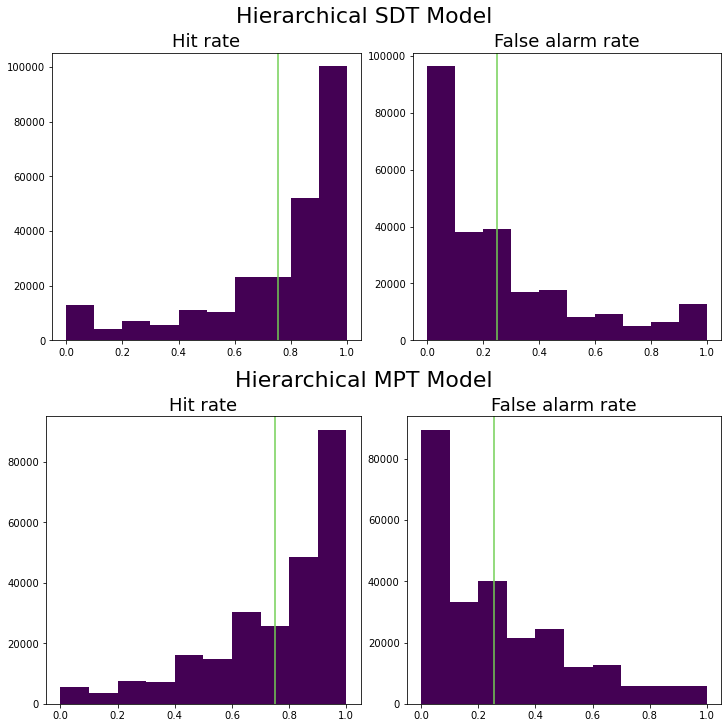

In [6]:
# Plot rates over all data sets

fig = plt.figure(constrained_layout=True, figsize=(10, 10))
subfigs = fig.subfigures(nrows=2, ncols=1)
subfigure_titles = ['Hierarchical SDT Model', 'Hierarchical MPT Model']

hit_rate_list = [sdt_hit_rates.flatten(), mpt_hit_rates.flatten()]
fa_rate_list = [sdt_fa_rates.flatten(), mpt_fa_rates.flatten()]

for row, subfig in enumerate(subfigs):
    subfig.suptitle(subfigure_titles[row], fontsize=22)

    # create 1x2 subplots per subfig
    axs = subfig.subplots(nrows=1, ncols=2)

    axs[0].hist(hit_rate_list[row], color='#440154FF')
    axs[0].set_title('Hit rate', fontsize=18)
    axs[0].axvline(np.mean(hit_rate_list[row]), color='#73D055FF')
    axs[1].hist(fa_rate_list[row], color='#440154FF')
    axs[1].set_title('False alarm rate', fontsize=18)
    axs[1].axvline(np.mean(fa_rate_list[row]), color='#73D055FF')

## Hit & false alarm rates (data set means)

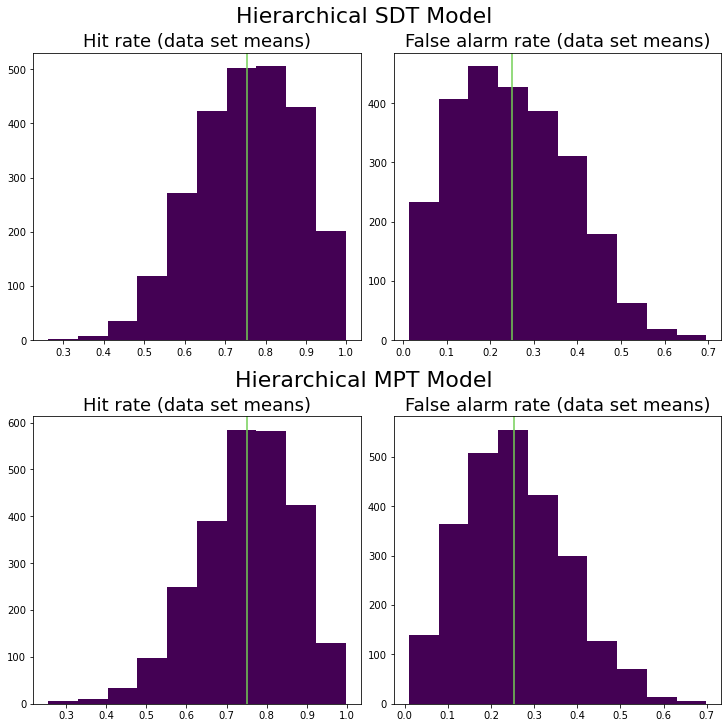

In [7]:
# Plot rate means of data sets

fig = plt.figure(constrained_layout=True, figsize=(10, 10))
subfigs = fig.subfigures(nrows=2, ncols=1)
subfigure_titles = ['Hierarchical SDT Model', 'Hierarchical MPT Model']

hit_rate_list = [np.mean(sdt_hit_rates, axis=1), np.mean(mpt_hit_rates, axis=1)]
fa_rate_list = [np.mean(sdt_fa_rates, axis=1), np.mean(mpt_fa_rates, axis=1)]

for row, subfig in enumerate(subfigs):
    subfig.suptitle(subfigure_titles[row], fontsize=22)

    # create 1x2 subplots per subfig
    axs = subfig.subplots(nrows=1, ncols=2)

    axs[0].hist(hit_rate_list[row], color='#440154FF')
    axs[0].set_title('Hit rate (data set means)', fontsize=18)
    axs[0].axvline(np.mean(hit_rate_list[row]), color='#73D055FF')
    axs[1].hist(fa_rate_list[row], color='#440154FF')
    axs[1].set_title('False alarm rate (data set means)', fontsize=18)
    axs[1].axvline(np.mean(fa_rate_list[row]), color='#73D055FF')

## Hit & false alarm probabilities (participants over all data sets)

In [8]:
def get_probs(simulator, model_index, n_data_sets, n_clusters):
    """_summary_

    Parameters
    ----------
    simulator : generative model object
        An initialized hierarchical simulator
    model_index : int
        Index coding the simulations from the targeted model.
    n_data_sets : int
        Number of data sets to simulate.
    n_clusters : int
        Number of higher order clusters that the observations are nested in.

    Returns
    -------
    hit_probs : np.array
        Hit probability per participant for each simulated data set with shape (n_data_sets, n_clusters).
    fa_probs : np.array
        False probability per participant for each simulated data set with shape (n_data_sets, n_clusters).
    """

    hit_probs = np.empty((n_data_sets, n_clusters))
    fa_probs = np.empty((n_data_sets, n_clusters))

    for d in range(n_data_sets):
        hit_probs[d, :], fa_probs[d, :] = simulator.draw_from_prior(model_index=model_index, n_clusters=n_clusters)

    return hit_probs, fa_probs

In [9]:
# Get hit probabilities and false alarm probabilities
prob_simulator = HierarchicalSdtMptSimulator()
sdt_hit_probs, sdt_fa_probs = get_probs(simulator=prob_simulator, model_index=0, n_data_sets=n_data_sets, n_clusters=n_clusters)
mpt_hit_probs, mpt_fa_probs = get_probs(simulator=prob_simulator, model_index=1, n_data_sets=n_data_sets, n_clusters=n_clusters)

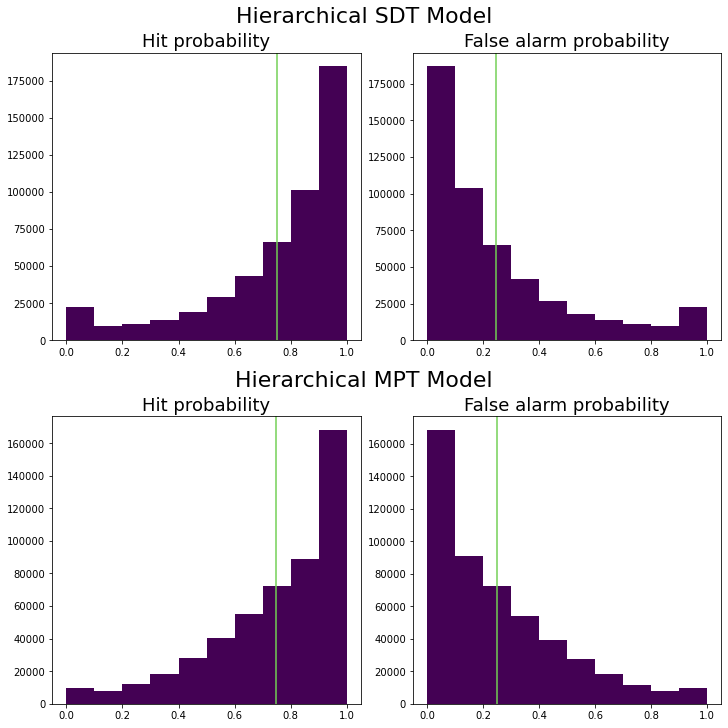

In [10]:
# Plot probabilities over all data sets

fig = plt.figure(constrained_layout=True, figsize=(10, 10))
subfigs = fig.subfigures(nrows=2, ncols=1)
subfigure_titles = ['Hierarchical SDT Model', 'Hierarchical MPT Model']

hit_rate_list = [sdt_hit_probs.flatten(), mpt_hit_probs.flatten()]
fa_rate_list = [sdt_fa_probs.flatten(), mpt_fa_probs.flatten()]

for row, subfig in enumerate(subfigs):
    subfig.suptitle(subfigure_titles[row], fontsize=22)

    # create 1x2 subplots per subfig
    axs = subfig.subplots(nrows=1, ncols=2)

    axs[0].hist(hit_rate_list[row], color='#440154FF')
    axs[0].set_title('Hit probability', fontsize=18)
    axs[0].axvline(np.mean(hit_rate_list[row]), color='#73D055FF')
    axs[1].hist(fa_rate_list[row], color='#440154FF')
    axs[1].set_title('False alarm probability', fontsize=18)
    axs[1].axvline(np.mean(fa_rate_list[row]), color='#73D055FF')